In [1]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
%config InlineBackend.figure_format='retina'

# Date libraries
from datetime import date, datetime, timedelta
import xlrd

# Machine Learning Libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# Load Datasets

In [2]:
xls = pd.ExcelFile('KPMG_VI_New_raw_data_update_final2.xlsx')
new_list = pd.read_excel(xls, 'NewCustomerList', skiprows=[0])
full_cluster = pd.read_csv('full_clustered.csv')
target_customers = pd.read_csv('high_value.csv')
RFM = pd.read_csv('RFMs.csv')

In [3]:
new_list.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,state,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,QLD,Australia,6,0.73,0.9125,1.140625,0.969531,1,1,1.718750
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,NSW,Australia,11,0.85,0.8500,1.062500,0.903125,1,1,1.718750
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,...,VIC,Australia,5,0.75,0.7500,0.750000,0.750000,1,1,1.718750
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,...,QLD,Australia,1,0.94,1.1750,1.175000,1.175000,4,4,1.703125
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,...,NSW,Australia,9,0.43,0.4300,0.537500,0.537500,4,4,1.703125


In [4]:
full_cluster.dtypes

transaction_id                           int64
product_id                               int64
customer_id                              int64
transaction_date                        object
online_order                           float64
order_status                            object
brand                                   object
product_line                            object
product_class                           object
product_size                            object
list_price                             float64
standard_cost                          float64
product_first_sold_date                 object
first_name                              object
last_name                               object
gender                                  object
past_3_years_bike_related_purchases      int64
job_title                               object
job_industry_category                   object
wealth_segment                          object
deceased_indicator                      object
owns_car     

In [5]:
new_list.dtypes

first_name                                     object
last_name                                      object
gender                                         object
past_3_years_bike_related_purchases             int64
DOB                                    datetime64[ns]
job_title                                      object
job_industry_category                          object
wealth_segment                                 object
deceased_indicator                             object
owns_car                                       object
tenure                                          int64
address                                        object
postcode                                        int64
state                                          object
country                                        object
property_valuation                              int64
Unnamed: 16                                   float64
Unnamed: 17                                   float64
Unnamed: 18                 

# Data Preparation

First we need to process the new customer dataset to match the preprocessing done on the old data.

Next we need to make sure the features match on both sets, with the exception of the cluster on the old dataset which will serve as a label for training data

In [6]:
def intersection(cols1, cols2):
    cols3 = [value for value in cols1 if value in cols2]
    return cols3

def not_intersection(cols1, cols2):
    cols3 = [value for value in cols1 if value not in cols2]
    return cols3

In [7]:
intersection(full_cluster.columns, new_list.columns)

['first_name',
 'last_name',
 'gender',
 'past_3_years_bike_related_purchases',
 'job_title',
 'job_industry_category',
 'wealth_segment',
 'deceased_indicator',
 'owns_car',
 'tenure',
 'address',
 'postcode',
 'state',
 'property_valuation']

In [8]:
not_intersection(full_cluster.columns, new_list.columns) 

['transaction_id',
 'product_id',
 'customer_id',
 'transaction_date',
 'online_order',
 'order_status',
 'brand',
 'product_line',
 'product_class',
 'product_size',
 'list_price',
 'standard_cost',
 'product_first_sold_date',
 'profit',
 'transaction_month',
 'AgeGroup',
 'cluster']

In [9]:
not_intersection(new_list.columns, full_cluster.columns) 

['DOB',
 'country',
 'Unnamed: 16',
 'Unnamed: 17',
 'Unnamed: 18',
 'Unnamed: 19',
 'Unnamed: 20',
 'Rank',
 'Value']

### New Customer Dataset

In [10]:
stage1 = new_list.drop(columns=['Unnamed: 16', 
                                'Unnamed: 17', 
                                'Unnamed: 18', 
                                'Unnamed: 19', 
                                'Unnamed: 20',
                                'Rank',
                                'Value'])

In [11]:
def clean_demographics(df):
    '''Function to carry out preprocessing on demographics dataset'''
    
    # Clean Gender column
    df['gender'].replace({'Female':'F', 'Male':'M', 'Femal':'F'}, inplace=True)
    
    # Clean Job title
    df['job_title'] = df['job_title'].str.replace(' V','').str.replace(' IV','').str.replace(' III','')
    df['job_title'] = df['job_title'].str.replace(' II','').str.replace(' I','')
    
    
    return df

def clean_address(df):
    '''UDF to clean customer address dataset'''
    
    # Standardize state names
    df['state'] = df['state'].replace({'New South Wales':'NSW','Victoria':'VIC'})
    
    # Drop redundant column
    df.drop(columns=['country'], inplace=True)
    return df

def engineered_features(df):
    
    # Age creation
    now = pd.Timestamp('now')
    df['age'] = (now - df['DOB']).astype('<m8[Y]') - 3
    
    # Age group creation
    bins= [0,10,18,30,50,120]
    labels = ['Kid','Teen','Young adult','Middle Aged','Elderly']
    df['AgeGroup'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
    df.drop(columns=['age','DOB'], inplace=True)
    return df

In [12]:
final_newlist = engineered_features(clean_address(clean_demographics(stage1)))

In [13]:
final_newlist.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,property_valuation,AgeGroup
0,Chickie,Brister,M,86,General Manager,Manufacturing,Mass Customer,N,Yes,14,45 Shopko Center,4500,QLD,6,Elderly
1,Morly,Genery,M,69,Structural Engineer,Property,Mass Customer,N,No,16,14 Mccormick Park,2113,NSW,11,Middle Aged
2,Ardelis,Forrester,F,10,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,10,5 Colorado Crossing,3505,VIC,5,Middle Aged
3,Lucine,Stutt,F,64,Account Representative,Manufacturing,Affluent Customer,N,Yes,5,207 Annamark Plaza,4814,QLD,1,Middle Aged
4,Melinda,Hadlee,F,34,Financial Analyst,Financial Services,Affluent Customer,N,No,19,115 Montana Place,2093,NSW,9,Elderly


In [15]:
final_newlist.dtypes

first_name                               object
last_name                                object
gender                                   object
past_3_years_bike_related_purchases       int64
job_title                                object
job_industry_category                    object
wealth_segment                           object
deceased_indicator                       object
owns_car                                 object
tenure                                    int64
address                                  object
postcode                                  int64
state                                    object
property_valuation                        int64
AgeGroup                               category
dtype: object

In [15]:
final_newlist.to_csv('new_list.csv', index=False)

### Old Customer Dataset

In [16]:
extra_columns = not_intersection(full_cluster.columns, final_newlist.columns) 
extra_columns.remove('cluster')

In [17]:
extra_columns

['transaction_id',
 'product_id',
 'customer_id',
 'transaction_date',
 'online_order',
 'order_status',
 'brand',
 'product_line',
 'product_class',
 'product_size',
 'list_price',
 'standard_cost',
 'product_first_sold_date',
 'profit',
 'transaction_month']

In [18]:
final_fullcluster = full_cluster.drop(columns=extra_columns)

# Check to make sure only the cluster label is left as the difference between both datasets
not_intersection(final_fullcluster.columns, final_newlist.columns) 

['cluster']

In [19]:
len(intersection(final_fullcluster.columns, final_newlist.columns))  == len(final_newlist.columns)

True

In [20]:
print(final_fullcluster.shape)
final_fullcluster.head(2)

(14062, 16)


,first_name,last_name,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,property_valuation,AgeGroup,cluster
0,Kristos,Anthony,M,19,Software Engineer,Financial Services,Mass Customer,N,Yes,10.0,984 Hoepker Court,3064,VIC,6,Elderly,1
1,Kristos,Anthony,M,19,Software Engineer,Financial Services,Mass Customer,N,Yes,10.0,984 Hoepker Court,3064,VIC,6,Elderly,1


In [21]:
print(final_newlist.shape)
final_newlist.head(2)

(1000, 15)


,first_name,last_name,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,property_valuation,AgeGroup
0,Chickie,Brister,M,86,General Manager,Manufacturing,Mass Customer,N,Yes,14,45 Shopko Center,4500,QLD,6,Elderly
1,Morly,Genery,M,69,Structural Engineer,Property,Mass Customer,N,No,16,14 Mccormick Park,2113,NSW,11,Middle Aged


# Machine Learning Model Development

Now we will begin building preparing the old dataset to be used for training/testing a decision tree.

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO 
from IPython.display import Image 
#from pydot import graph_from_dot_data

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [23]:
final_fullcluster['cluster'].value_counts()

2    5268
0    4352
1    2352
3    2090
Name: cluster, dtype: int64

In [24]:
final_fullcluster.dtypes

first_name                              object
last_name                               object
gender                                  object
past_3_years_bike_related_purchases      int64
job_title                               object
job_industry_category                   object
wealth_segment                          object
deceased_indicator                      object
owns_car                                object
tenure                                 float64
address                                 object
postcode                                 int64
state                                   object
property_valuation                       int64
AgeGroup                                object
cluster                                  int64
dtype: object

In [25]:
# Turn categorical variables into numbers and fill missing
def convert_to_categories(df):
    
    for column, contents in df.items():
        if pd.api.types.is_string_dtype(contents):
            df[column] = contents.astype("category").cat.as_ordered()    
    return df

def fill_missing(df):
    # Fill missing categorical data, and note missing instances
    for feature, value in df.items():
        
        if not pd.api.types.is_numeric_dtype(value):
            #df[feature+"_was_missing"] = pd.isnull(value)
           
            # Add +1 to th category code since pandas encodes missing values as -1
            df[feature] = pd.Categorical(value).codes+1      
    return df

def fm(df):
    for label, content in final_fullcluster.items():
        if not pd.api.types.is_numeric_dtype(content): 
            # Add a binary column which tells us if the data was missing originally
            
            # Turn categories into numbers and add +1
            final_fullcluster[label] = pd.Categorical(content).codes+1
    return df

In [26]:
final_fullcluster = convert_to_categories(final_fullcluster)

In [28]:
final_fullcluster2 = final_fullcluster.drop(columns=['first_name','last_name'])
final_fullcluster2 = fill_missing(final_fullcluster2)


In [29]:
final_fullcluster2.dtypes

gender                                    int8
past_3_years_bike_related_purchases      int64
job_title                                 int8
job_industry_category                     int8
wealth_segment                            int8
deceased_indicator                        int8
owns_car                                  int8
tenure                                 float64
address                                  int16
postcode                                 int64
state                                     int8
property_valuation                       int64
AgeGroup                                  int8
cluster                                  int64
dtype: object

In [30]:
final_fullcluster2.isna().sum()

gender                                 0
past_3_years_bike_related_purchases    0
job_title                              0
job_industry_category                  0
wealth_segment                         0
deceased_indicator                     0
owns_car                               0
tenure                                 0
address                                0
postcode                               0
state                                  0
property_valuation                     0
AgeGroup                               0
cluster                                0
dtype: int64

In [31]:
X = final_fullcluster2.drop(columns=['cluster'])                                    
y = final_fullcluster2['cluster']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)

for each in[X_train, X_test, y_train, y_test]:
    print(each.shape)

(11249, 13)
(2813, 13)
(11249,)
(2813,)


In [33]:
X_train.head()

,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,property_valuation,AgeGroup
5468,1,88,112,3,1,1,2,10.0,154,2749,1,8,2
9301,1,3,75,5,3,1,2,12.0,1062,2153,1,10,2
1528,2,98,53,8,2,1,1,17.0,593,2095,1,9,1
1578,1,25,11,8,1,1,1,1.0,753,4214,2,9,3
2758,1,33,6,3,3,1,2,9.0,1056,4210,2,10,4


### Build models

In [54]:
models = {"Decision Tree": DecisionTreeClassifier(criterion='entropy', max_depth=10),
          "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10)}

def fit_then_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models: a dict of different Scikit-Learn machine learning models
    """
    
    # Set random seed
    np.random.seed(42)
    # MAke a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        #Evaluate the model and append it's score to model scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [55]:
model_scores = fit_then_score(models=models, 
                              X_train=X_train,
                              X_test=X_test,
                              y_train=y_train,
                              y_test=y_test)

model_scores

{'Decision Tree': 0.58833985069321, 'Random Forest': 0.8016352648418059}

In [56]:
X.dtypes

gender                                    int8
past_3_years_bike_related_purchases      int64
job_title                                 int8
job_industry_category                     int8
wealth_segment                            int8
deceased_indicator                        int8
owns_car                                  int8
tenure                                 float64
address                                  int16
postcode                                 int64
state                                     int8
property_valuation                       int64
AgeGroup                                  int8
dtype: object

In [59]:
# Create hyper parameter grid for RandomForrestClassifier()
rf_grid = {"n_estimators": np.arange(5, 50, 5),
           "max_depth": [ 3, 5, 10, 15, 20],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(3, 20, 2)}

# Create hyper parameter grid for DecisionTreeClassifier()
dt_grid = {"criterion": ['gini'],
           "max_depth": [4],
           "min_samples_split": np.arange(20, 100, 5),
           "min_samples_leaf": np.arange(15, 100, 5)}

In [89]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier()
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier()
rs_rf.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   23.2s finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [3, 5, 10, 15, 20],
                                        'min_samples_leaf': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45])},
                   verbose=True)

In [60]:
# Setup random hyperparameter search for DecisionTreeClassifier()
rs_dt = RandomizedSearchCV(DecisionTreeClassifier(),
                           param_distributions=dt_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier()
rs_dt.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=20,
                   param_distributions={'criterion': ['gini'], 'max_depth': [4],
                                        'min_samples_leaf': array([15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]),
                                        'min_samples_split': array([20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95])},
                   verbose=True)

In [61]:
rs_dt.best_params_

{'min_samples_split': 45,
 'min_samples_leaf': 15,
 'max_depth': 4,
 'criterion': 'gini'}

In [92]:
rs_rf.score(X_test, y_test)

0.9761820120867402

In [62]:
rs_dt.score(X_test, y_test)

0.3913970849626733

In [63]:
y_preds = rs_dt.predict(X_test)

In [64]:
accuracy = metrics.accuracy_score(y_test, y_preds)
print("Accuracy: {:.2f}".format(accuracy))
cm=confusion_matrix(y_test,y_preds)
print('Confusion Matrix: \n', cm)
print(classification_report(y_test, y_preds))

Accuracy: 0.39
Confusion Matrix: 
 [[434   4 410  23]
 [212  13 224  21]
 [392   2 636  24]
 [166   2 232  18]]
              precision    recall  f1-score   support

           0       0.36      0.50      0.42       871
           1       0.62      0.03      0.05       470
           2       0.42      0.60      0.50      1054
           3       0.21      0.04      0.07       418

    accuracy                           0.39      2813
   macro avg       0.40      0.29      0.26      2813
weighted avg       0.40      0.39      0.34      2813



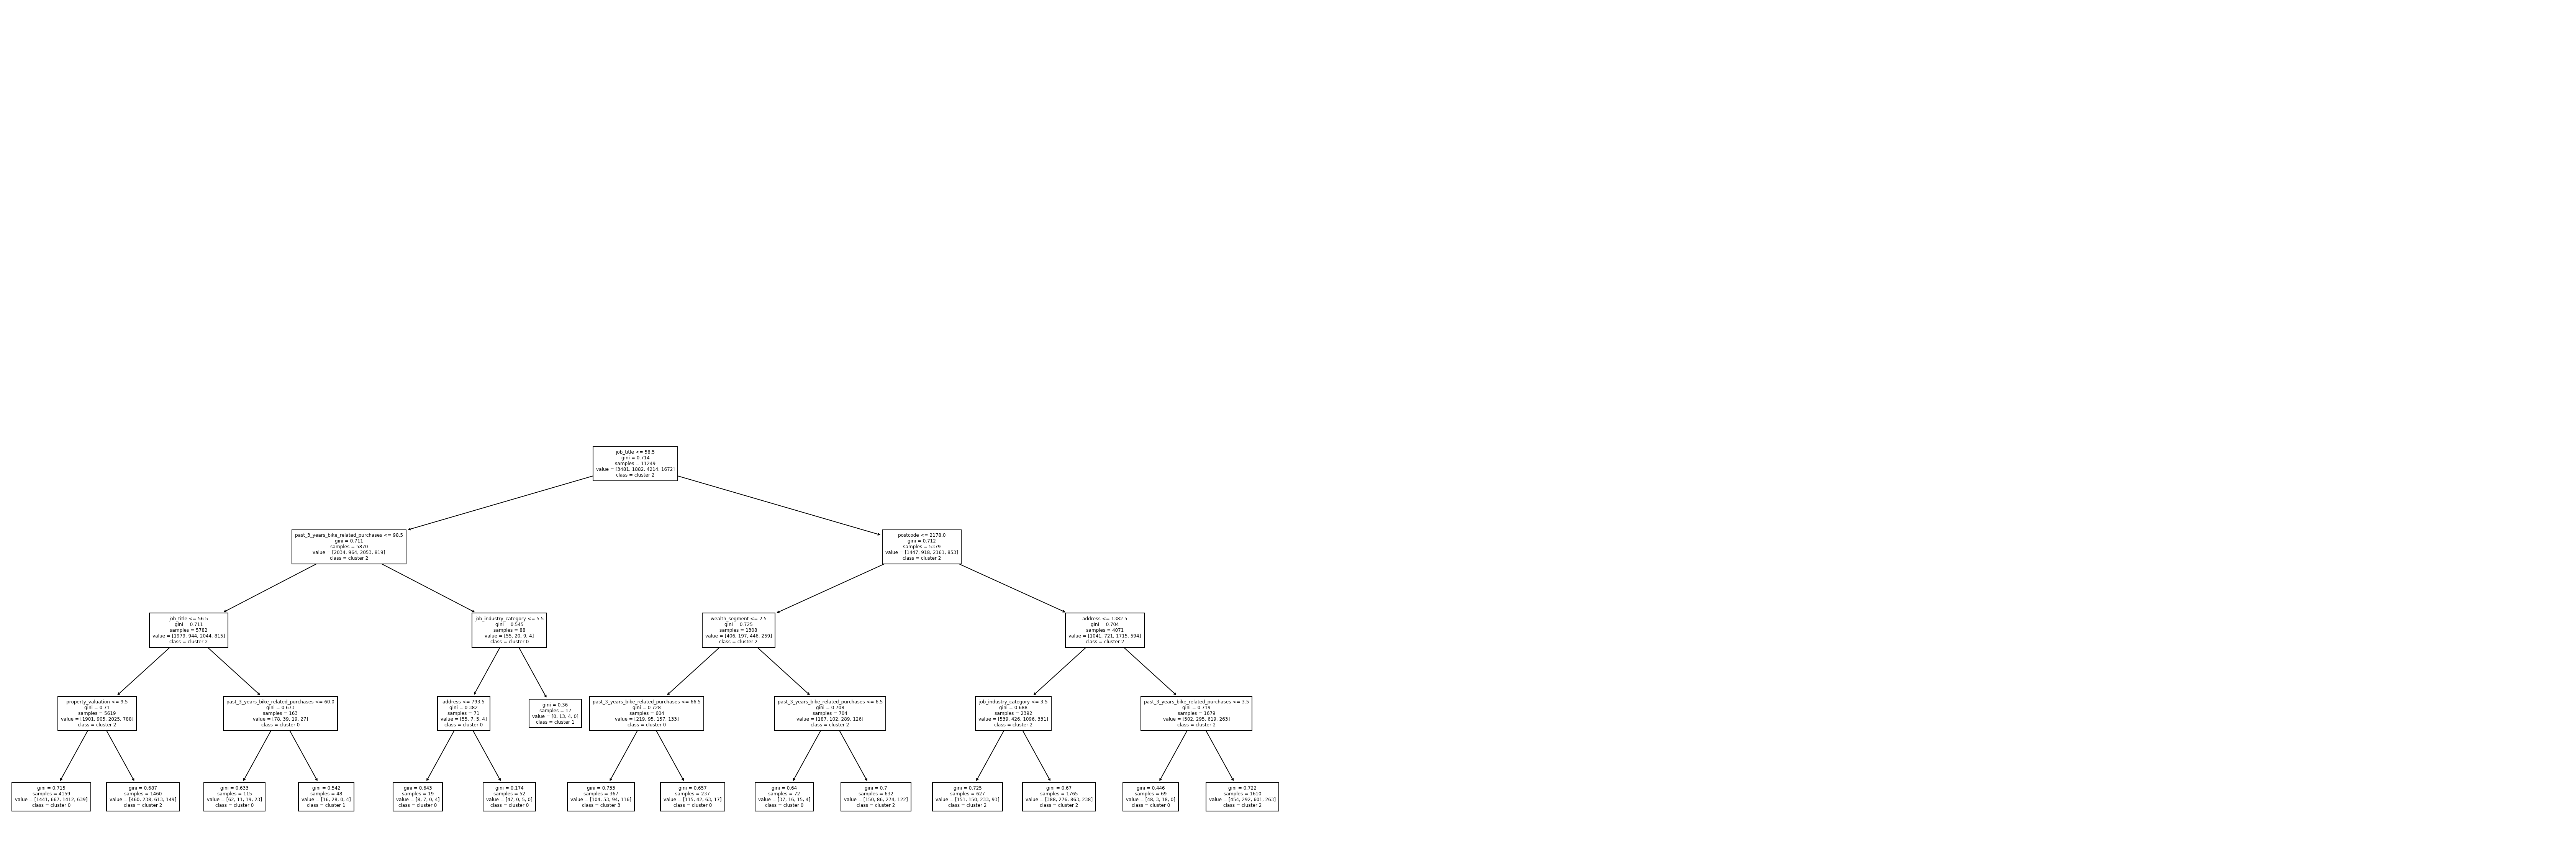

In [71]:
# Visualize the tree by graphiz
import graphviz
from sklearn import tree
#feature_names = X_train.columns
#dot_data = tree.export_graphviz(rs_dt.best_estimator_, out_file=None, filled=True, rounded = True, feature_names=feature_names)
#graph = graphviz.Source(dot_data)
#graph

plt.figure(figsize=(60,20))
tree.plot_tree(rs_dt.best_estimator_, fontsize=6, feature_names=X_train.columns, class_names=['cluster 0',
                                                                                              'cluster 1',
                                                                                              'cluster 2',
                                                                                              'cluster 3'])
plt.savefig('tree_high_dpi', dpi=100)
